In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import torch
import random

import numpy as np
from torch import nn
import torch.nn.functional as F

In [2]:
int_to_label = {
    0: "non-object",
    1: "person",
    2: "birds",
    3: "parking meter",
    4: "stop sign",
    5: "street sign",
    6: "fire hydrant",
    7: "traffic light",
    8: "motorcycle",
    9: "bicycle",
    10: "LMVs",
    11: "HMVs",
    12: "animals",
    13: "poles",
    14: "barricades",
    15: "traffic cones",
    16: "mailboxes",
    17: "stones",
    18: "small walls",
    19: "bins",
    20: "furniture",
    21: "pot plant",
    22: "sign boards",
    23: "boxes",
    24: "trees",
}

# Generate 24 distinct colors
int_to_color = {i: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in range(25)}

In [3]:
from ultralytics import RTDETR
model = RTDETR('yolo/runs/train/rtdetr_custom_4/weights/best.pt')
torch.save( model.state_dict, 'models/pre_trained/rtdetr-c.pth' )

## Hooks

In [4]:
# Hook variables
enc_score_head_outputs = None
encoder_outputs = None

# Hook functions
def hook_fn(module, input, output):
    global enc_score_head_outputs
    enc_score_head_outputs = ( input, output )

def hook_fn_encoder(module, input, output):
    global encoder_outputs
    encoder_outputs = ( input, output )

# Register the hook
model.model.model[32].decoder.register_forward_hook(hook_fn)
model.model.model[31].register_forward_hook(hook_fn_encoder)

In [5]:
img_name = 'test_images/8.png'
import cv2
image = cv2.imread( img_name )
image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB )
torch_image = torch.from_numpy( image ).permute( 2, 0, 1 ).float() / 255.0

In [6]:
r = model( img_name )


image 1/1 /home/lucas/capstone/test_images/8.png: 640x640 1 Person, 1 Street Sign, 4 Traffic Lights, 9 LMVss, 6 Poless, 2 Binss, 3 Sign Boardss, 1 Trees, 64.6ms
Speed: 2.1ms preprocess, 64.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


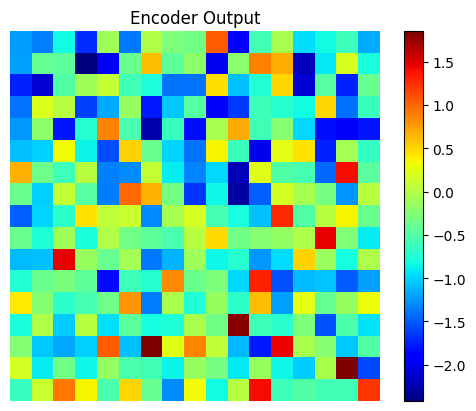

In [7]:
img = enc_score_head_outputs[0][0][0,:289].reshape( 17, 17, 256 )
idx = 0
# plot the heatmap
plt.imshow( img[:,:,idx].cpu().detach().numpy(), cmap = 'jet' )
plt.axis( 'off' )
plt.colorbar()
plt.title( "Encoder Output" )
plt.show()

In [ ]:
f_80_80 = enc_score_head_outputs[1][0][:80*80].reshape( 80, 80, 256 )
f_40_40 = enc_score_head_outputs[1][0][80*80:80*80+40*40].reshape( 40, 40, 256 )
f_20_20 = enc_score_head_outputs[1][0][80*80+40*40:80*80+40*40+20*20].reshape( 20, 20, 256 )
f_80_80.min(), f_80_80.max(), f_40_40.min(), f_40_40.max(), f_20_20.min(), f_20_20.max()

In [ ]:
idx = 0
# plot the heatmap
plt.imshow( f_80_80[:,:,idx].cpu().detach().numpy(), cmap = 'jet' )
plt.axis( 'off' )
plt.colorbar()
plt.title( "Encoder Output" )
plt.show()

In [ ]:
idx = 0
# plot the heatmap
plt.imshow( f_40_40[:,:,idx].cpu().detach().numpy(), cmap = 'jet' )
plt.axis( 'off' )
plt.colorbar()
plt.title( "Encoder Output" )
plt.show()

In [ ]:
idx = 0
# plot the heatmap
plt.imshow( f_20_20[:,:,idx].cpu().detach().numpy(), cmap = 'jet' )
plt.axis( 'off' )
plt.colorbar()
plt.title( "Encoder Output" )
plt.show()

In [ ]:
print( encoder_outputs[0][0].shape )
idx = 0
img = encoder_outputs[0][0][0][idx]

# plot the heatmap
plt.imshow( img.cpu().detach().numpy(), cmap = 'jet' )
plt.axis( 'off' )
plt.colorbar()
plt.title( "Encoder Output" )
plt.show()

In [ ]:
print( encoder_outputs[1][0].shape )
idx = 0
img = encoder_outputs[1][0][idx]

# plot the heatmap
plt.imshow( img.cpu().detach().numpy(), cmap = 'jet' )
plt.axis( 'off' )
plt.colorbar()
plt.title( "Encoder Output" )
plt.show()

In [ ]:
img.min(), img.max()

In [ ]:
im_with_boxes = r[0].plot()

plt.figure(figsize=(15, 15))
plt.imshow(im_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
# shapes = [(80, 80), (40, 40), (20, 20)]

# # Get the outputs from the hook
# enc_outputs_scores = enc_score_head_outputs[0].to('cpu')  # [bs, h*w, num_classes]

# # Get shape information
# bs, hw_total, num_classes = enc_outputs_scores.shape

# # Apply softmax to the scores
# enc_outputs_scores = F.softmax(enc_outputs_scores, dim=-1)

# # Get the max scores and labels
# scores, pred_label = enc_outputs_scores.max(-1)

# # Mask out non-object scores (label=0)
# masked_scores = scores.clone()
# masked_scores = torch.where(pred_label == 0, masked_scores, 10*masked_scores)

# # get top-k tokens and values from the all 3 feature maps
# topk_values, topk_indices = torch.topk( masked_scores.view( bs, -1 ), 300, dim = 1 )
# topk_indices = topk_indices[0]  # shape: (300,)
# topk_values  = topk_values[0]   # shape: (300,)
# indices_idx = torch.arange( 0, 300 )  # shape: (300,)

# level0_end = shapes[0][0] * shapes[0][1]
# level1_end = level0_end + shapes[1][0] * shapes[1][1]
# level2_end = level1_end + shapes[2][0] * shapes[2][1]  # Should equal hw_total

# # Isolate tokens for level 0: indices in [0, level0_end)
# mask0 = ( topk_indices < level0_end )
# top_indices_feat_0 = topk_indices[mask0]
# top_values_feat_0  = topk_values[mask0]
# indices_idx_feat_0 = indices_idx[mask0]

# # Isolate tokens for level 1: indices in [level0_end, level1_end)
# mask1 = ( topk_indices >= level0_end ) & ( topk_indices < level1_end )
# top_indices_feat_1 = topk_indices[mask1] - level0_end
# top_values_feat_1  = topk_values[mask1]
# indices_idx_feat_1 = indices_idx[mask1]

# # Isolate tokens for level 2: indices in [level1_end, level2_end)
# mask2 = ( topk_indices >= level1_end ) & ( topk_indices < level2_end )
# top_indices_feat_2 = topk_indices[mask2] - level1_end  # local index if desired
# top_values_feat_2  = topk_values[mask2]
# indices_idx_feat_2 = indices_idx[mask2]

# all_top_indices = [ top_indices_feat_0, top_indices_feat_1, top_indices_feat_2 ]
# all_top_values = [ top_values_feat_0, top_values_feat_1, top_values_feat_2 ]
# all_top_indices_idx = [ indices_idx_feat_0, indices_idx_feat_1, indices_idx_feat_2 ]

# # Get original image dimensions
# original_h, original_w = image.shape[0:2]

# # Create a heatmap matrix for the original image
# heatmap_overlay = np.zeros((original_h, original_w), dtype=np.float32)

# # Define different colors for each scale (used for filled circles; edge will be green)
# colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

# # Create a figure to visualize each scale separately
# plt.figure(figsize=(20, len(shapes)*10))
# for i, ( (h, w), indices, values, dxs ) in enumerate( zip( shapes, all_top_indices, all_top_values, all_top_indices_idx ) ):
    
#     # Scale factors to map feature map coordinates to original image
#     scale_y, scale_x = original_h / h, original_w / w
    
#     # Radius of the circle to draw (proportional to scale)
#     circle_radius = max( 1, int( min( scale_y, scale_x ) // 2 ) )
    
#     # Create a scale-specific heatmap
#     scale_heatmap = np.zeros( ( original_h, original_w ), dtype = np.float32 )
    
#     # Create a list to store coordinates for proposals that are in the detectors_ list.
#     detector_coords = []
    
#     # For each top-k index, map to original image and accumulate score
#     for j, (idx, val, dx) in enumerate( zip( indices, values, dxs ) ):

#         # Convert feature map index to 2D position
#         idx = idx.item()
#         feat_y, feat_x = idx // w, idx % w
        
#         # Map to original image coordinates (center of the feature cell)
#         orig_y = int( ( feat_y + 0.5 ) * scale_y )
#         orig_x = int( ( feat_x + 0.5 ) * scale_x )
        
#         # Ensure within bounds
#         orig_y = min( max( 0, orig_y ), original_h-1 )
#         orig_x = min( max( 0, orig_x ), original_w-1 )
        
#         # Get score value
#         score_val = val.item()
        
#         # Draw filled circle on both heatmaps
#         cv2.circle( heatmap_overlay, ( orig_x, orig_y ), circle_radius, score_val, -1 )
#         cv2.circle( scale_heatmap, ( orig_x, orig_y ), circle_radius, score_val, -1 )
    
#     # Normalize the scale-specific heatmap
#     if scale_heatmap.max() > 0:
#         scale_heatmap = scale_heatmap / scale_heatmap.max()
    
#     # Display the scale-specific heatmap
#     plt.subplot( len( shapes ), 1, i + 1 )
#     plt.imshow( image )
#     plt.imshow( scale_heatmap, cmap = 'hot', alpha = 0.5 )

        
#     plt.title(f'Scale {i+1} ({h}x{w}) - Top-300 Proposals')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# # Normalize the combined heatmap
# if heatmap_overlay.max() > 0:
#     heatmap_overlay = heatmap_overlay / heatmap_overlay.max()

# # Apply colormap to heatmap
# heatmap_color = cv2.applyColorMap( ( heatmap_overlay * 255 ).astype( np.uint8 ), cv2.COLORMAP_JET )
# heatmap_color = cv2.cvtColor( heatmap_color, cv2.COLOR_BGR2RGB )

# # Convert image to RGB copy for blending
# image_rgb = image.copy()

# # Create blended overlay
# alpha = 0.5
# blended = cv2.addWeighted( image_rgb, 1-alpha, heatmap_color, alpha, 0 )

# # Show the final visualization
# plt.figure( figsize = ( 20, 20 ) )
# plt.imshow( blended )
# plt.title( "Object Proposals Heatmap Overlay" )
# plt.axis( 'off' )
# plt.tight_layout()
# plt.show()

In [ ]:
print("AIFI(\n  (ma): MultiheadAttention(\n    (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)\n  )\n  (fc1): Linear(in_features=384, out_features=2048, bias=True)\n  (fc2): Linear(in_features=2048, out_features=384, bias=True)\n  (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)\n  (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)\n  (dropout): Dropout(p=0, inplace=True)\n  (dropout1): Dropout(p=0, inplace=True)\n  (dropout2): Dropout(p=0, inplace=True)\n  (act): GELU(approximate='none')\n)")